In [12]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt

from utils_reconstruction import image_similarity as imsim
import tifffile


In [3]:
## load reconstruction .npy files
num_neurons = [7863, 7908, 8202, 7939, 8122]
mouse_names = [
    "dynamic29515-10-12-Video-9b4f6a1a067fe51e15306b9628efea20",
    "dynamic29623-4-9-Video-9b4f6a1a067fe51e15306b9628efea20",
    "dynamic29647-19-8-Video-9b4f6a1a067fe51e15306b9628efea20",
    "dynamic29712-5-9-Video-9b4f6a1a067fe51e15306b9628efea20",
    "dynamic29755-2-8-Video-9b4f6a1a067fe51e15306b9628efea20",
]

max_num_neurons = np.max(num_neurons)
model_list = np.array([0,1,2,3,4,5,6]) # 0,1,2,3,4,5,6
mice = np.array([0])
dirs = np.array([0,1,2,3])# range(0,4)
spatial_length_constant = range(0,4)
temporal_length_constant = range(0,7)
eval_frame_skip = 30 # default 32
mask_th = 1

video_gt=np.nan*np.ones((len(mice),len(dirs),len(spatial_length_constant),len(temporal_length_constant),60,36,64))
video_pred=np.nan*np.ones((model_list.size,len(mice),len(dirs),len(spatial_length_constant),len(temporal_length_constant),60,36,64))
responses_pred_gt=np.nan*np.ones((model_list.size,len(mice),len(dirs),len(spatial_length_constant),len(temporal_length_constant),max_num_neurons,60))
responses_pred_recon=np.nan*np.ones((model_list.size,len(mice),len(dirs),len(spatial_length_constant),len(temporal_length_constant),max_num_neurons,60))
mask=np.nan*np.ones((len(mice),36,64))


for model_n in range(0,model_list.size):
    for mouse in range(0,len(mice)):
        for dir in range(0,len(dirs)):#reps:
            for spatial_n in spatial_length_constant:
                for temporal_n in temporal_length_constant:
                        
                    datapath=f'../reconstructions/modelfold{model_list[model_n]}_round4_Drifting_gratings/reconstruction_summary_m{mice[mouse]}_d{dirs[dir]}s{spatial_n}t{temporal_n}.npy' 
                    print(datapath)
                    data = np.load(datapath, allow_pickle=True).item()
                    if model_n==model_list[0]:
                        video_gt[mouse,dir,spatial_n,temporal_n] = data['video_gt']

                    video_pred[model_n-1,mouse,dir,spatial_n,temporal_n] = data['video_pred']
                    mask[mouse-1] = data['mask'][14:14+36,:]
                    responses_pred_gt[model_n-1,mouse,dir,spatial_n,temporal_n,0:num_neurons[mice[mouse]],:] = data['responses_predicted_gt']
                    responses_pred_recon[model_n-1,mouse-1,dir,spatial_n,temporal_n,0:num_neurons[mice[mouse]],:] = data['responses_predicted_full']
                    
# remove eval grace period
video_gt = video_gt[:,:,:,:,eval_frame_skip:,:,:]
video_pred = video_pred[:,:,:,:,:,eval_frame_skip:,:,:]
responses_pred_gt = responses_pred_gt[:,:,:,:,eval_frame_skip:]
responses_pred_recon = responses_pred_recon[:,:,:,:,eval_frame_skip:]

print('video_gt: ', video_gt.shape, video_gt.min(), video_gt.max())     
print('video_pred: ', video_pred.shape, video_pred.min(), video_pred.max())
print('mask: ', mask.shape, mask.min(), mask.max())

video_pred = np.clip(video_pred, 0, 255) # not sure i need this... but just in case

video_pred_Amean_all = np.nanmean(video_pred, axis=0) # mean across models, no smoothing

../reconstructions/modelfold0_round4_Drifting_gratings/reconstruction_summary_m0_d0s0t0.npy
../reconstructions/modelfold0_round4_Drifting_gratings/reconstruction_summary_m0_d0s0t1.npy
../reconstructions/modelfold0_round4_Drifting_gratings/reconstruction_summary_m0_d0s0t2.npy
../reconstructions/modelfold0_round4_Drifting_gratings/reconstruction_summary_m0_d0s0t3.npy
../reconstructions/modelfold0_round4_Drifting_gratings/reconstruction_summary_m0_d0s0t4.npy
../reconstructions/modelfold0_round4_Drifting_gratings/reconstruction_summary_m0_d0s0t5.npy
../reconstructions/modelfold0_round4_Drifting_gratings/reconstruction_summary_m0_d0s0t6.npy
../reconstructions/modelfold0_round4_Drifting_gratings/reconstruction_summary_m0_d0s1t0.npy
../reconstructions/modelfold0_round4_Drifting_gratings/reconstruction_summary_m0_d0s1t1.npy
../reconstructions/modelfold0_round4_Drifting_gratings/reconstruction_summary_m0_d0s1t2.npy
../reconstructions/modelfold0_round4_Drifting_gratings/reconstruction_summary_m0

In [4]:
# correlation between video_gt and video_pred for each dir, spatial and temporal frequency
print('video_gt: ', video_gt.shape, video_gt.min(), video_gt.max())
print('video_pred_Amean_all: ', video_pred_Amean_all.shape, video_pred_Amean_all.min(), video_pred_Amean_all.max())

all_corr = np.zeros((len(mice),len(dirs),len(spatial_length_constant),len(temporal_length_constant)))
for mouse in mice:
    for dir in range(0,len(dirs)):
        for spatial_n in spatial_length_constant:
            for temporal_n in temporal_length_constant:
                all_corr[mouse-1,dir,spatial_n,temporal_n] = imsim.reconstruction_video_corr(video_gt[mouse-1,dir,spatial_n,temporal_n],
                                                                                           video_pred_Amean_all[mouse-1,dir,spatial_n,temporal_n],
                                                                                           np.where(mask[mouse-1] >= mask_th,1,0))

# mean corr across mice and dirs
mean_corr_ensembled = np.nanmean(all_corr, axis=(0,1))
print('mean_corr shape: ', mean_corr_ensembled.shape)
print('mean corr across dirs', np.nanmean(all_corr, axis=(0,2,3)))

all_mean_corr = np.zeros((len(model_list),len(mice),len(dirs),len(spatial_length_constant),len(temporal_length_constant)))
for model_n in range(0,model_list.size):
    for mouse in mice:
        for dir in range(0,len(dirs)):
            for spatial_n in spatial_length_constant:
                for temporal_n in temporal_length_constant:
                    all_mean_corr[model_n-1,mouse-1,dir,spatial_n,temporal_n] = imsim.reconstruction_video_corr(video_gt[mouse-1,dir,spatial_n,temporal_n],
                                                                                            video_pred[model_n-1,mouse-1,dir,spatial_n,temporal_n],
                                                                                            np.where(mask[mouse-1] >= mask_th,1,0))

mean_corr = np.nanmean(all_mean_corr, axis=(0,1,2))

video_gt:  (1, 4, 4, 7, 30, 36, 64) 0.0 255.0
video_pred_Amean_all:  (1, 4, 4, 7, 30, 36, 64) 1.2502260548727853 248.43329511369978
mean_corr shape:  (4, 7)
mean corr across dirs [0.41746802 0.43111074 0.41458841 0.4059032 ]


In [5]:
# contrast adjust images
# for each movie, take the mean image across all time points, then calculate the mean and std of that image
# normalize the predicted images by subtracting the mean and dividing by the std
mouse_n,dir_n,slc,tlc,frame_n, h_n, w_n = video_gt.shape[0],video_gt.shape[1],video_gt.shape[2],video_gt.shape[3],video_gt.shape[4],video_gt.shape[5],video_gt.shape[6]

expanded_mask = np.expand_dims(np.where(mask>= mask_th,1,np.nan) ,axis=(1,2,3,4)).repeat(dir_n,axis=-6).repeat(slc,axis=-5) .repeat(tlc,axis=-4).repeat(frame_n,axis=-3)

# get target mean and std
video_gt_frame_mean = video_gt * expanded_mask
target_means = np.nanmean(video_gt_frame_mean, axis=(-1,-2,-3))
target_stds = np.nanstd(video_gt_frame_mean, axis=(-1,-2,-3))

# get start mean and std
video_pred_frame_mean = video_pred_Amean_all * expanded_mask
start_means = np.nanmean(video_pred_frame_mean, axis=(-1,-2,-3))
start_stds = np.nanstd(video_pred_frame_mean, axis=(-1,-2,-3))

# expand dims of mean and std in time h and w
target_means = np.expand_dims(target_means,axis=(4,5,6)).repeat(frame_n,axis=-3).repeat(h_n,axis=-2).repeat(w_n,axis=-1)
target_stds = np.expand_dims(target_stds,axis=(4,5,6)).repeat(frame_n,axis=-3).repeat(h_n,axis=-2).repeat(w_n,axis=-1)
start_means = np.expand_dims(start_means,axis=(4,5,6)).repeat(frame_n,axis=-3).repeat(h_n,axis=-2).repeat(w_n,axis=-1)
start_stds = np.expand_dims(start_stds,axis=(4,5,6)).repeat(frame_n,axis=-3).repeat(h_n,axis=-2).repeat(w_n,axis=-1)

# # z-score predicted video
video_pred_zscore = (video_pred_Amean_all - start_means)  / start_stds
video_pred_norm = (video_pred_zscore*target_stds) + target_means
video_pred_norm = np.clip(video_pred_norm, 0, 255)

# reaply mask
video_gt_masked = video_gt * expanded_mask#np.expand_dims(expanded_mask ,axis=(-3)).repeat(frame_n,axis=-3)
video_pred_Amean_all_masked = video_pred_Amean_all * expanded_mask#p.expand_dims(expanded_mask ,axis=(-3)).repeat(frame_n,axis=-3)
video_pred_norm_masked = video_pred_norm * expanded_mask#np.expand_dims(expanded_mask ,axis=(-3)).repeat(frame_n,axis=-3)

video_gt_masked[np.isnan(video_gt_masked)] = 255/2
video_pred_Amean_all_masked[np.isnan(video_pred_Amean_all_masked)] = 255/2
video_pred_norm_masked[np.isnan(video_pred_norm_masked)] = 255/2

In [6]:
data = np.load('../utils_reconstruction/grating_movies.npz', allow_pickle=True)
print(data.files)
drifting_sf_in_pix = data['drifting_sf_in_pix'] # correction by 2
drifting_sf_in_deg = data['drifting_sf_in_deg'] # correction by 2
drifting_tf_sec = data['drifting_temporal_frequencies']
drifting_tf_frames = drifting_tf_sec/30 # this might have changed to tf
print('drifting_sf_in_pix: ' , np.round(drifting_sf_in_pix,3))
print('drifting_sf_in_deg: ' , np.round(drifting_sf_in_deg,3))
print('drifting_tf_in_sec: ' , drifting_tf_sec)
print('drifting_tf_frames: ' , drifting_tf_frames)

tf_n = len(drifting_tf_frames)
sf_n = len(drifting_sf_in_deg)

['video', 'drifting_directions', 'drifting_sf_in_pix', 'drifting_sf_in_deg', 'drifting_temporal_frequencies']
drifting_sf_in_pix:  [0.5   0.25  0.125 0.062]
drifting_sf_in_deg:  [0.143 0.071 0.036 0.018]
drifting_tf_in_sec:  [15.       7.5      3.75     1.875    0.9375   0.46875  0.     ]
drifting_tf_frames:  [0.5      0.25     0.125    0.0625   0.03125  0.015625 0.      ]


h_min, h_max, w_min, w_max:  3 31 17 45
h, w:  28 28
videos_gt_tiled:  (30, 112, 196)


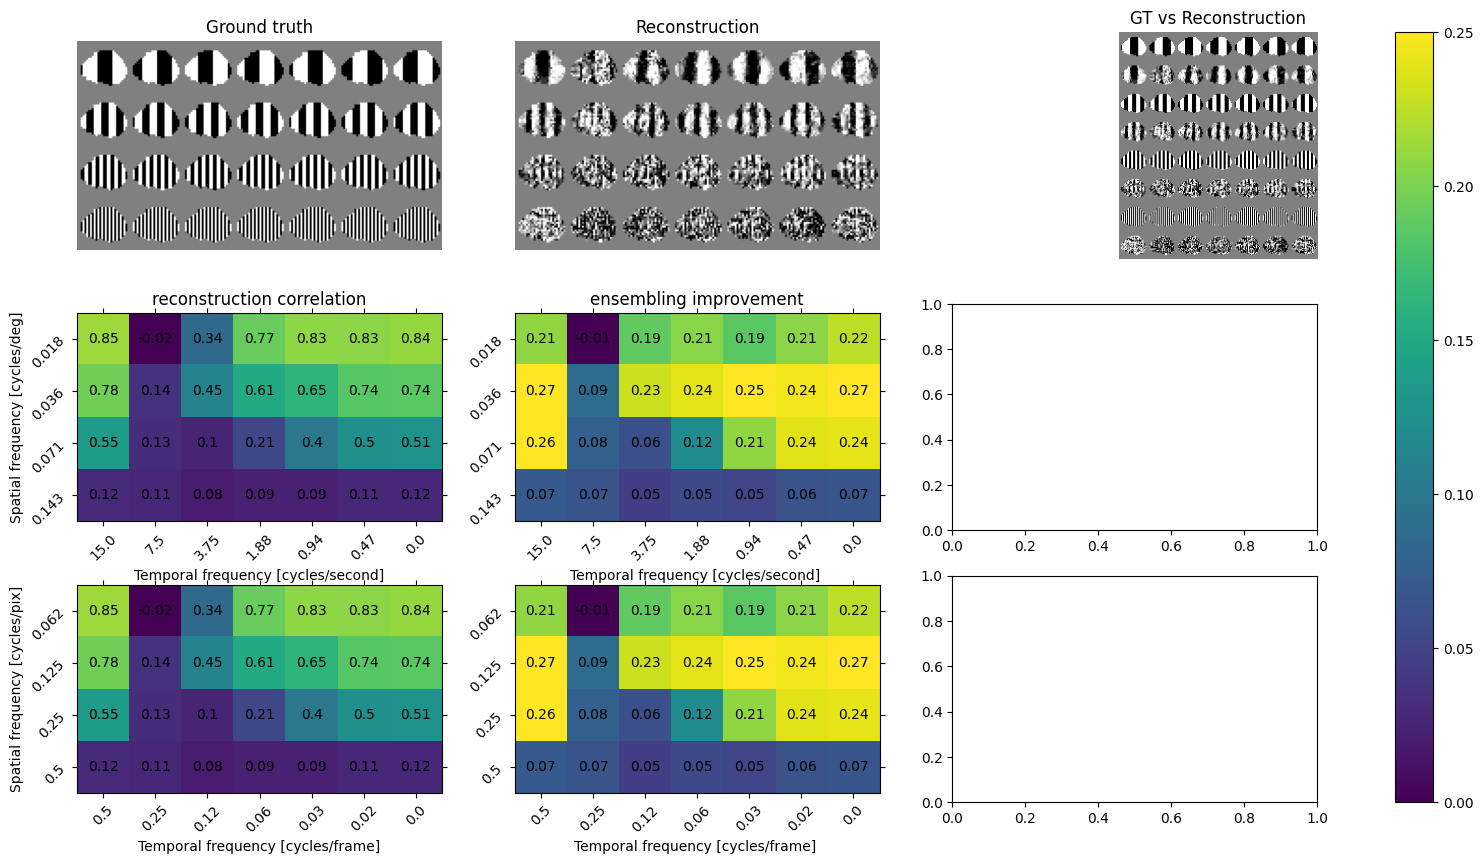

In [8]:
fig, axs = plt.subplots(3,3, figsize=(20,10))

axs[1,0].imshow(mean_corr_ensembled, cmap='viridis', vmin=0, vmax=1)
axs[1,0].invert_yaxis()
axs[1,0].set_yticks(np.arange(sf_n), np.round(drifting_sf_in_deg,3), rotation=45)
axs[1,0].set_xticks(np.arange(tf_n), np.round(drifting_tf_sec,2), rotation=45)
axs[1,0].set_xlabel('Temporal frequency [cycles/second]')
axs[1,0].set_ylabel('Spatial frequency [cycles/deg]')
axs[1,0].tick_params(bottom=True, top=True, left=True, right=True)
#set axis square
axs[1,0].set_title('reconstruction correlation')
for i in range(tf_n):
    for j in range(sf_n):
        c = mean_corr_ensembled[j,i]
        axs[1,0].text(i, j, str(round(c, 2)), 
                 va='center', ha='center')

fig.colorbar(axs[1,1].imshow(mean_corr_ensembled-mean_corr, cmap='viridis', vmin=0, vmax=0.25),ax=axs)
axs[1,1].invert_yaxis()
axs[1,1].set_yticks(np.arange(sf_n), np.round(drifting_sf_in_deg,3), rotation=45)
axs[1,1].set_xticks(np.arange(tf_n), np.round(drifting_tf_sec,2), rotation=45)
axs[1,1].set_xlabel('Temporal frequency [cycles/second] ')
axs[1,1].tick_params(bottom=True, top=True, left=True, right=True)
#set axis square
# axs[1,1].set_box_aspect(1)
axs[1,1].set_title('ensembling improvement')
for i in range(tf_n):
    for j in range(sf_n):
        c = mean_corr_ensembled[j,i]-mean_corr[j,i]
        axs[1,1].text(i, j, str(round(c, 2)), 
                 va='center', ha='center')

# now with respect to pix and frames
axs[2,0].imshow(mean_corr_ensembled, cmap='viridis', vmin=0, vmax=1)
axs[2,0].invert_yaxis()
axs[2,0].set_yticks(np.arange(sf_n), np.round(drifting_sf_in_pix,3), rotation=45)
axs[2,0].set_xticks(np.arange(tf_n), np.round(drifting_tf_frames,2), rotation=45)
axs[2,0].set_xlabel('Temporal frequency [cycles/frame]')
axs[2,0].set_ylabel('Spatial frequency [cycles/pix]')
axs[2,0].tick_params(bottom=True, top=True, left=True, right=True)
#set axis square
for i in range(tf_n):
    for j in range(sf_n):
        c = mean_corr_ensembled[j,i]
        axs[2,0].text(i, j, str(round(c, 2)), 
                 va='center', ha='center')

axs[2,1].imshow(mean_corr_ensembled-mean_corr, cmap='viridis', vmin=0, vmax=0.25)
axs[2,1].invert_yaxis()
axs[2,1].set_yticks(np.arange(sf_n), np.round(drifting_sf_in_pix,3), rotation=45)
axs[2,1].set_xticks(np.arange(tf_n), np.round(drifting_tf_frames,2), rotation=45)
axs[2,1].set_xlabel('Temporal frequency [cycles/frame] ')
axs[2,1].tick_params(bottom=True, top=True, left=True, right=True)
#set axis square
for i in range(tf_n):
    for j in range(sf_n):
        c = mean_corr_ensembled[j,i]-mean_corr[j,i]
        axs[2,1].text(i, j, str(round(c, 2)), 
                 va='center', ha='center')


# apply crop to masks based
mask_expanded = np.expand_dims(mask,axis=(1)).repeat(video_gt.shape[-3],axis=1)
mask_all = np.where(np.sum(np.where(mask >= mask_th,1,0),axis=0) >= 1,1,0)
mask_all_idx = np.where(mask_all == 1)
h_min, h_max = np.min(mask_all_idx[0])-2, np.max(mask_all_idx[0])+2
w_min, w_max = np.min(mask_all_idx[1])-2, np.max(mask_all_idx[1])+2
h = h_max - h_min
w = w_max - w_min
# make square
h_min, h_max = h_min - (w-h)//2, h_max + (w-h)//2 
h = h_max - h_min
w = w_max - w_min

print('h_min, h_max, w_min, w_max: ', h_min, h_max, w_min, w_max)
print('h, w: ', h, w)

vid_length = video_gt.shape[-3]
dir_plot = 0

# tile combined videos

videos_gt_tiled_masked = video_gt[0,:,:,:,:,:,:]
videos_gt_tiled_masked = videos_gt_tiled_masked * np.where(mask_expanded[0,-1] >= mask_th,1,0) + (1-np.where(mask_expanded[0,-1] >= mask_th,1,0) )*255/2
videos_gt_tiled_masked= videos_gt_tiled_masked[:,::-1,:,:,h_min:h_max,w_min:w_max]# crop and flip spatial length constant orders

videos_recon_tiled = video_pred_norm_masked[0,:,:,:,:,:,:]
videos_recon_tiled = videos_recon_tiled * np.where(mask_expanded[0,-1] >= mask_th,1,0)  + (1-np.where(mask_expanded[0,-1] >= mask_th,1,0))*255/2
videos_recon_tiled = videos_recon_tiled[:,::-1,:,:,h_min:h_max,w_min:w_max] # crop flip spatial length constant orders


# vertical cat
videos_interleaved = np.concatenate((videos_gt_tiled_masked[:,None,:],videos_recon_tiled[:,None,:]), axis=1)
videos_interleaved = np.moveaxis(np.moveaxis(videos_interleaved,-3,1).reshape((4*vid_length,2,sf_n,tf_n,h,w)),0,-3) # concatenate directions
videos_interleaved = np.moveaxis(np.moveaxis(videos_interleaved,0,1).reshape((2*sf_n,tf_n,4*vid_length,h,w)),0,0) # tile gt and recon
videos_interleaved = np.moveaxis(np.moveaxis(videos_interleaved,-2,1).reshape((2*sf_n*h,tf_n,4*vid_length,w)),0,-2) # tile sf
videos_interleaved = np.moveaxis(np.moveaxis(videos_interleaved,-1,1).reshape((tf_n*w,4*vid_length,sf_n*h*2)),0,-1) # tile tf

# tile separate videos
videos_gt_tiled_masked = video_gt[0,dir_plot,:,:,:,:,:]
videos_gt_tiled_masked = videos_gt_tiled_masked * np.where(mask_expanded[0,-1] >= mask_th,1,0) + (1-np.where(mask_expanded[0,-1] >= mask_th,1,0) )*255/2
videos_gt_tiled_masked= videos_gt_tiled_masked[:,:,:,h_min:h_max,w_min:w_max]
videos_gt_tiled_masked = videos_gt_tiled_masked[::-1,:,:,:,:] # flip spatial and temporal length constant orders
videos_gt_tiled_masked = np.moveaxis(np.moveaxis(videos_gt_tiled_masked,-2,1).reshape((sf_n*h,tf_n,vid_length,w)),0,-2) # tile sf
videos_gt_tiled_masked = np.moveaxis(np.moveaxis(videos_gt_tiled_masked,-1,1).reshape((tf_n*w,vid_length,sf_n*h)),0,-1) # tile tf

videos_recon_tiled = video_pred_norm_masked[0,dir_plot,:,:,:,:,:]
videos_recon_tiled = videos_recon_tiled * np.where(mask_expanded[0,-1] >= mask_th,1,0)  + (1-np.where(mask_expanded[0,-1] >= mask_th,1,0))*255/2
videos_recon_tiled = videos_recon_tiled[::-1,:,:,h_min:h_max,w_min:w_max]
videos_recon_tiled = np.moveaxis(np.moveaxis(videos_recon_tiled,-2,1).reshape((sf_n*h,tf_n,vid_length,w)),0,-2) # tile sf
videos_recon_tiled = np.moveaxis(np.moveaxis(videos_recon_tiled,-1,1).reshape((tf_n*w,vid_length,sf_n*h)),0,-1) # tile tf
print('videos_gt_tiled: ', videos_gt_tiled_masked.shape)

axs[0,0].imshow(videos_gt_tiled_masked[0], cmap='gray')
axs[0,0].set_axis_off()
axs[0,0].set_title('Ground truth')

axs[0,1].imshow(videos_recon_tiled[0], cmap='gray')
axs[0,1].set_axis_off()
axs[0,1].set_title('Reconstruction')


axs[0,2].imshow(videos_interleaved[0], cmap='gray')
axs[0,2].set_axis_off()
axs[0,2].set_title('GT vs Reconstruction')



fig.savefig('../reconstructions/Drifting_gratings_reconstruction.svg', format='svg', dpi=1200)

# save video as tiff
tifffile.imwrite('../reconstructions/Drifting_gratings_reconstruction.tiff', 
                 # np concatenate videos along time axis
                videos_interleaved.astype(np.uint8),
                imagej=True,
                metadata = {'unit': 'um','fps': 30.0,'axes': 'TYX',})
